## Tarea 2

In [1]:
import csv
from pyspark import SparkContext
import timeit
import datetime
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
sc=SparkContext()
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

24/12/22 17:30:54 WARN Utils: Your hostname, Zhijie resolves to a loopback address: 127.0.1.1; using 192.168.93.152 instead (on interface wlo1)
24/12/22 17:30:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 17:30:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/22 17:30:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
def configure_data(line):
    """
    Convierte una línea del archivo CSV en un par clave-valor.

    Args:
        line (str): Línea del archivo CSV.

    Returns:
        tuple: Una tupla `(key, value)` donde:
            - `key`: Tupla `(User, Model, gt)` como identificador.
            - `value`: Tupla con datos para cálculos agregados.
        Devuelve `(None, None)` si el valor `gt` es `'null'`.
    """
    datas = line.split(',')
    if datas[9] == 'null':
        return None, None

    x = float(datas[3])
    y = float(datas[4])
    z = float(datas[5])
    key = (datas[6], datas[7], datas[9])
    value = (
        x, y, z,
        x**2, y**2, z**2,
        x, y, z,
        x, y, z,
        1
    )

    return key, value

def filter_data(data):
    """
    Filtra registros con claves nulas.

    Args:
        data (tuple): Una tupla `(key, value)`.

    Returns:
        bool: `True` si la clave no es `None`, de lo contrario `False`.
    """
    key, _ = data
    if key is None:
        return False
    return True

def reduce_data(a, b):
    """
    Combina dos tuplas de datos para agregar valores (sumatorias, mínimos, máximos, conteo).

    Args:
        a (tuple): Primera tupla con valores acumulados.
        b (tuple): Segunda tupla con valores acumulados.

    Returns:
        tuple: Una tupla con los valores combinados.
    """
    sum_x = a[0] + b[0]
    sum_y = a[1] + b[1]
    sum_z = a[2] + b[2]
    sum_x2 = a[3] + b[3]
    sum_y2 = a[4] + b[4]
    sum_z2 = a[5] + b[5]
    max_x = max(a[6], b[6])
    max_y = max(a[7], b[7])
    max_z = max(a[8], b[8])
    min_x = min(a[9], b[9])
    min_y = min(a[10], b[10])
    min_z = min(a[11], b[11])
    count = a[12] + b[12]
    return (
        sum_x, sum_y, sum_z,
        sum_x2, sum_y2, sum_z2,
        max_x, max_y, max_z,
        min_x, min_y, min_z,
        count
    )

def calculate_data(data):
    """
    Calcula métricas como la media, desviación estándar, máximo y mínimo por eje.

    Args:
        data (tuple): Tupla `(key, aggregated_values)`.

    Returns:
        tuple: Tupla `(key, metrics)` donde `metrics` incluye las métricas calculadas.
    """
    key, value = data
    sum_x, sum_y, sum_z, sum_x2, sum_y2, sum_z2, max_x, max_y, max_z, min_x, min_y, min_z, count = value
    mean_x = sum_x / count
    mean_y = sum_y / count
    mean_z = sum_z / count
    std_x = (sum_x2 / count - mean_x**2)**0.5
    std_y = (sum_y2 / count - mean_y**2)**0.5
    std_z = (sum_z2 / count - mean_z**2)**0.5
    return key, (mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z)

def simplify_data(data):
    """
    Combina datos de giroscopios y acelerómetros en una sola estructura.

    Args:
        data (tuple): Tupla `(key, (value1, value2))`.

    Returns:
        tuple: Tupla `(key, combined_values)` con todos los datos combinados.
    """
    key, (value1, value2) = data
    combined_values = value1 + value2
    return key, combined_values

def split_data(data):
    datas = data.split(',')
    # We use bool for unused column to reduce memory usage
    return bool(datas[0]), bool(datas[1]), bool(datas[2]), float(datas[3]), float(datas[4]), float(datas[5]), datas[6], datas[7], datas[8], datas[9]

def load_and_preprocess(file_path, schema):
    return spark.read.csv(file_path, schema=schema, nullValue="null")

def compute_group_statistics(data):
    return data.groupBy(data['user'], data['model'], data['gt']).agg(
        F.mean(data['x']).alias('mean_x'),
        F.mean(data['y']).alias('mean_y'),
        F.mean(data['z']).alias('mean_z'),
        F.stddev(data['x']).alias('std_x'),
        F.stddev(data['y']).alias('std_y'),
        F.stddev(data['z']).alias('std_z'),
        F.max(data['x']).alias('max_x'),
        F.max(data['y']).alias('max_y'),
        F.max(data['z']).alias('max_z'),
        F.min(data['x']).alias('min_x'),
        F.min(data['y']).alias('min_y'),
        F.min(data['z']).alias('min_z')
    )
def get_parquet_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    return total_size

def get_csv_file_size(file_path):
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path)
        return file_size
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")

fields = [
    StructField("_index", BooleanType(), False), StructField("_arrive", BooleanType(), False), StructField("_creation", BooleanType(), False),
    StructField("x", DoubleType(), False), StructField("y", DoubleType(), False), StructField("z", DoubleType(), False),
    StructField("user", StringType(), False), StructField("model", StringType(), False), StructField("_device", StringType(), False),
    StructField("gt", StringType(), False)
]
schema = StructType(fields)

### Apartado 1

In [3]:
ori_folder = "original/"
sml_folder = "small/"

file_names = ["Phones_accelerometer", "Phones_gyroscope", "Watch_accelerometer", "Watch_gyroscope"]

for file_name in file_names:
    if not os.path.exists(sml_folder+file_name+".parquet"):
        data = load_and_preprocess(sml_folder+file_name+".csv", schema)
        data.write.save(sml_folder+file_name+".parquet")
    
    if not os.path.exists(ori_folder+file_name+".parquet"):
        data = load_and_preprocess(ori_folder+file_name+".csv", schema)
        data.write.save(ori_folder+file_name+".parquet")


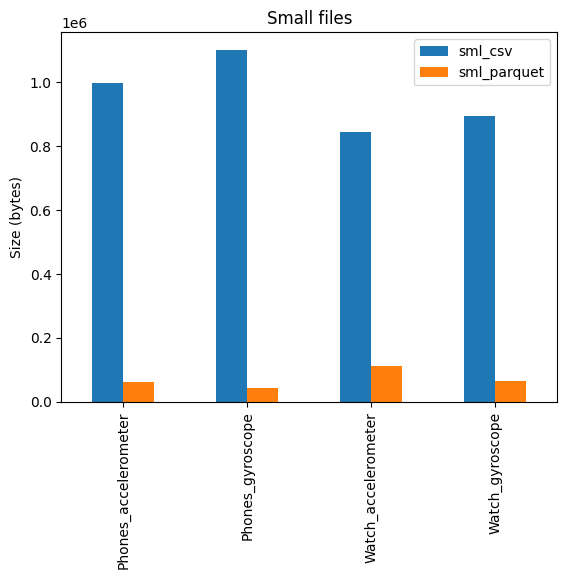

                      sml_csv  sml_parquet
Phones_accelerometer   997515        61409
Phones_gyroscope      1100646        42037
Watch_accelerometer    842763       111834
Watch_gyroscope        894796        65614


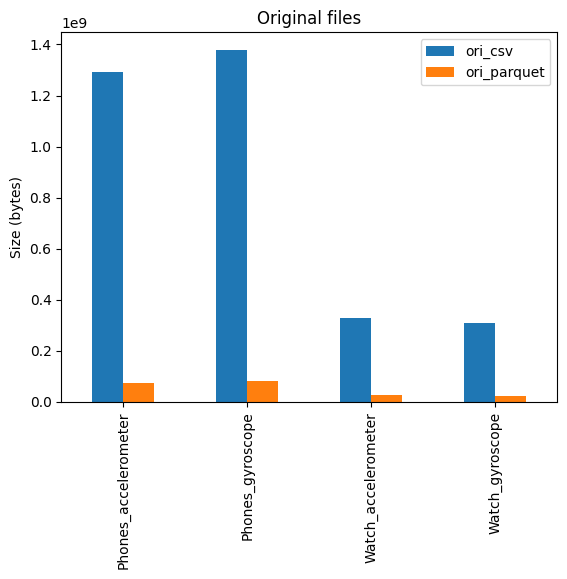

                         ori_csv  ori_parquet
Phones_accelerometer  1291856327     73804953
Phones_gyroscope      1379145657     80561783
Watch_accelerometer    327168052     26367149
Watch_gyroscope        308337025     22012309


24/12/22 17:31:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
ori_csv = []
sml_csv = []
ori_parquet = []
sml_parquet = []

for file_name in file_names:
    ori_csv.append(get_csv_file_size(ori_folder+file_name+".csv"))
    sml_csv.append(get_csv_file_size(sml_folder+file_name+".csv"))
    ori_parquet.append(get_parquet_folder_size(ori_folder+file_name+".parquet"))
    sml_parquet.append(get_parquet_folder_size(sml_folder+file_name+".parquet"))

sm_df = pd.DataFrame({
    "sml_csv": sml_csv,
    "sml_parquet": sml_parquet
}, index=file_names)

sm_df.plot(kind='bar')
plt.title("Small files")
plt.ylabel("Size (bytes)")
plt.show()
print(sm_df)

or_df = pd.DataFrame({
    "ori_csv": ori_csv,
    "ori_parquet": ori_parquet
}, index=file_names)

or_df.plot(kind='bar')
plt.title("Original files")
plt.ylabel("Size (bytes)")
plt.show()
print(or_df)

Conviertiendo el fichero csv en parquet, se puede observar una reducción increible del tamaño del fichero en las gráficas de arriba. Además de las gráficas, se ha pintado el tamaño de los ficheros en bytes y se puede comprobar que efectivamente, el fichero parquet es muchísimo más pequeño que el csv.

### Apartado 2

#### Caso 1

In [ ]:
a = datetime.datetime.now()
data1 = sc.textFile(ori_folder+'Phones_accelerometer.csv', 8)
data2 = sc.textFile(ori_folder+'Phones_gyroscope.csv', 8)
data3 = sc.textFile(ori_folder+'Watch_accelerometer.csv', 8)
data4 = sc.textFile(ori_folder+'Watch_gyroscope.csv', 8)

r_data1 = data1.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data2 = data2.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data3 = data3.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)
r_data4 = data4.map(configure_data).filter(filter_data).reduceByKey(reduce_data).map(calculate_data)

phones = r_data1.join(r_data2).map(simplify_data)
watch = r_data3.join(r_data4).map(simplify_data)

result = phones.union(watch).collect()
b = datetime.datetime.now()
print (b-a)

0:00:19.693591


[(('h', 's3', 'bike'),
  (-2.1814330423855264,
   -0.6397758058709374,
   9.238672634687886,
   1.0964790647128768,
   1.3347597413799588,
   1.3987926518403648,
   1.532289,
   2.834735,
   14.393941,
   -5.0757074,
   -4.0892963,
   4.673482,
   0.056076031803150926,
   -0.029697872445752876,
   -0.20711533920196598,
   0.6830302448872504,
   0.6404640400788258,
   0.41927750709972267,
   1.4569136,
   1.6074919,
   1.1591167,
   -1.3490959999999999,
   -1.9837848999999999,
   -1.4871514)),
 (('a', 's3', 'stairsup'),
  (-6.64356508365157,
   1.3633977963463464,
   6.846974648718749,
   2.521261092500312,
   1.788928127734642,
   2.3361299063520393,
   -1.733402,
   9.797073,
   16.64449,
   -16.251839999999998,
   -5.2863975,
   1.2066777,
   -0.2690650674460128,
   0.001507258492064661,
   0.3176161043340415,
   0.6933932312313159,
   0.5054434472190662,
   0.6726685631680842,
   2.3225097999999997,
   1.9013181000000001,
   3.4837644,
   -2.9810223999999996,
   -1.9504926999999999,

En el caso 1, se ha utilizado lo que se hizo de la práctica 5, donde se calcula la media, la destivación, el máximo y el mínimo agrupando poco a poco los datos en vez de utilizar una función como puede ser np.mean o np.std, también se hizo un filtrado de datos donde se ignoraba las acciones que tiene valor "null", y el tiempo que tarda en ejecutarse es de 19 segundos.

#### Caso 2

In [ ]:
a = datetime.datetime.now()
data1 = spark.createDataFrame(sc.textFile(ori_folder+'Phones_accelerometer.csv', 8).map(split_data), schema)
data2 = spark.createDataFrame(sc.textFile(ori_folder+'Phones_gyroscope.csv', 8).map(split_data), schema)
data3 = spark.createDataFrame(sc.textFile(ori_folder+'Watch_accelerometer.csv', 8).map(split_data), schema)
data4 = spark.createDataFrame(sc.textFile(ori_folder+'Watch_gyroscope.csv', 8).map(split_data), schema)

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)

24/12/22 17:31:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


0:00:36.397577


[Row(user='a', model='nexus4', gt='stairsdown', mean_x=-5.967048322757208, mean_y=0.24671655695026856, mean_z=7.987391944811866, std_x=2.888407121623275, std_y=1.4427580489377303, std_z=2.743890694092616, max_x=3.2824097, max_y=10.890778, max_z=23.507782000000002, min_x=-20.907944, min_y=-8.5108795, min_z=-0.22709656, mean_x=0.23859804216855204, mean_y=-0.05694916242437909, mean_z=-0.30900799602920576, std_x=0.5618766694119697, std_y=0.5348385070139673, std_z=0.7237000819894078, max_x=2.7197266, max_y=5.2955017, max_z=4.597931, min_x=-2.8932189999999998, min_y=-2.4931946, min_z=-4.0476684999999994),
 Row(user='a', model='nexus4', gt='stairsup', mean_x=-6.40959676879888, mean_y=1.179849406519905, mean_z=7.383135664728942, std_x=2.6718987776714798, std_y=1.7028464609354614, std_z=2.3046246826076646, max_x=-0.9094238000000001, max_y=10.168335, max_z=16.340485, min_x=-17.31018, min_y=-5.7027893, min_z=2.342514, mean_x=-0.2843921229827755, mean_y=0.010409764841895623, mean_z=0.3107890454499

Como tenemos que crear Dataframe a partir de los RDDs, primero se tuvo generar los RDDs, luego se tuvo que crear los Dataframes con la definición de los esquemas, y por último se tuvo que realizar las operaciones necesarias para producir los resultados. Como existe un paso extra de la conversión de RDD y Dataframe, el tiempo que se ha tardado se ha incrementado considerablemente, tardando unos 36 segundos.

#### Caso 3

In [ ]:
a = datetime.datetime.now()
data1 = spark.read.load(ori_folder+"Phones_accelerometer.parquet")
data2 = spark.read.load(ori_folder+"Phones_gyroscope.parquet")
data3 = spark.read.load(ori_folder+"Watch_accelerometer.parquet")
data4 = spark.read.load(ori_folder+"Watch_gyroscope.parquet")

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)

0:00:03.681905


[Row(user='f', model='nexus4', gt='stand', mean_x=-1.5523042395875275, mean_y=-0.06401136558920928, mean_z=9.852060233290018, std_x=0.18127446212565354, std_y=0.2437050652141571, std_z=0.2700655992777258, max_x=-0.39050293, max_y=1.6902008000000002, max_z=10.804932, min_x=-2.904007, min_y=-1.2848206, min_z=8.640976, mean_x=-0.0011725763587866794, mean_y=0.0016017087555331858, mean_z=1.9725395876172333e-05, std_x=0.019426835446969725, std_y=0.03525225009858148, std_z=0.06977471164059118, max_x=0.22697449, max_y=0.41738892, max_z=0.598114, min_x=-0.24424744, min_y=-0.30999756, min_z=-1.0126038),
 Row(user='e', model='s3', gt='sit', mean_x=3.888339039771663, mean_y=0.1972540928621869, mean_z=8.798702756304607, std_x=0.08598291907300804, std_y=0.13385194193624467, std_z=0.1575784721464278, max_x=4.4244847, max_y=2.5761611, max_z=9.864111, min_x=1.283292, min_y=-1.1204863999999999, min_z=8.101977999999999, mean_x=0.005182354104946986, mean_y=-0.006390151299477613, mean_z=0.01660018887928207

Este sería el caso más óptimo, donde en vez de leer un fichero csv, leemos un fichero parquet que ya por sí es óptima tanto a nivel de tamaño en disco como a nivel de lectura de datos por fila, además ya se incluye la información del esquema dentro del fichero en vez de tener que definirlo manualmente. Con todas estas ventajas, el tiempo que se tarda en ejecutar es de 3 segundos.

#### Caso 4

In [44]:
a = datetime.datetime.now()
data1 = load_and_preprocess(ori_folder+"Phones_accelerometer.csv", schema)
data2 = load_and_preprocess(ori_folder+"Phones_gyroscope.csv", schema)
data3 = load_and_preprocess(ori_folder+"Watch_accelerometer.csv", schema)
data4 = load_and_preprocess(ori_folder+"Watch_gyroscope.csv", schema)

group1 = compute_group_statistics(data1)
group2 = compute_group_statistics(data2)
group3 = compute_group_statistics(data3)
group4 = compute_group_statistics(data4)

join1 = group1.join(group2, ['user', 'model', 'gt'], 'inner')
join2 = group3.join(group4, on=['user', 'model', 'gt'], how='inner')

results = join1.union(join2).collect()
b = datetime.datetime.now()
print (b-a)

0:00:10.072972


En este caso, se utiliza directamente la función spark.read.csv pasando el esquema, pero al no estar optimizado tanto a nivel de disco ni a nivel de lectura de datos por fila, se producirá muchísimos fallos de cache relantizando el proceso entero, tardando un tiempo de 10 segundos.